<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/Consolidated_GEFS_ML_Max_Temp_Min_Temp_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

CUDA Available: False
PyTorch not available
Current Date and Time (UTC): 2025-06-18 14:11:11
Current User's Login: m-wessler
--------------------------------------------------
Starting ML Post-Processing Workflow
Model: XGBOOST
Stations: KBOI, KSLC, KSEA, KLAS
Forecast Hours: 024
--------------------------------------------------
Loading data for 4 station(s) and 1 forecast hour(s)...
Multi-station mode: 'hgt_sfc' and 'elev_ft' will be included as features
  Loading file: /content/KBOI_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSLC_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSEA_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KLAS_2000_2009_f024.csv
  Successfully loaded 18265 rows
Combined dataset: 73060 rows, 49 columns
Added day-of-year feature
Excluded 6 variables: ['sid', 'state', 'init_datetime', 'fcst_hour', 'perturbation', 'tmin_obs']
Dropped 1 non-numeric columns: ['station_id']
F

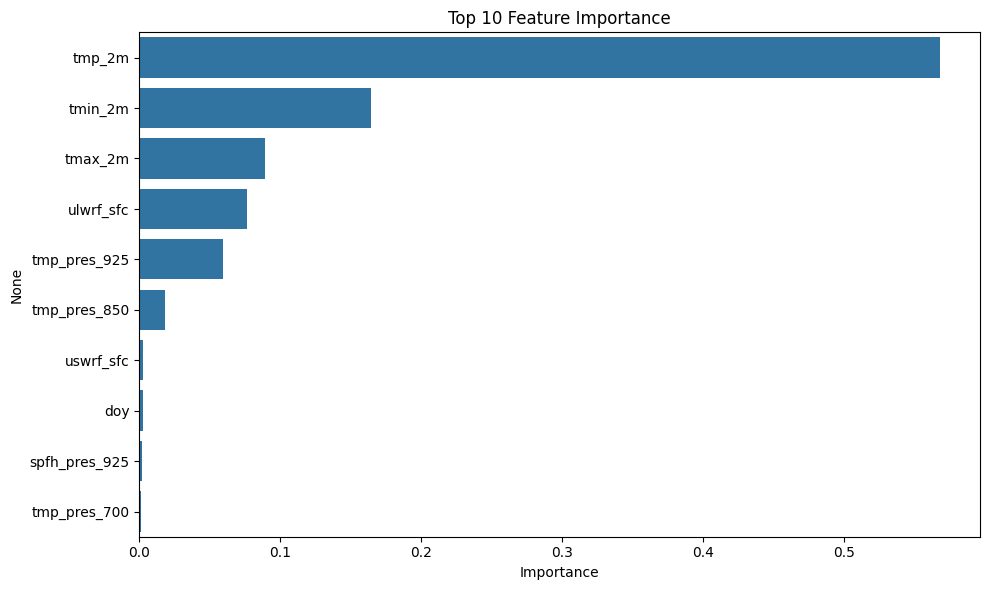

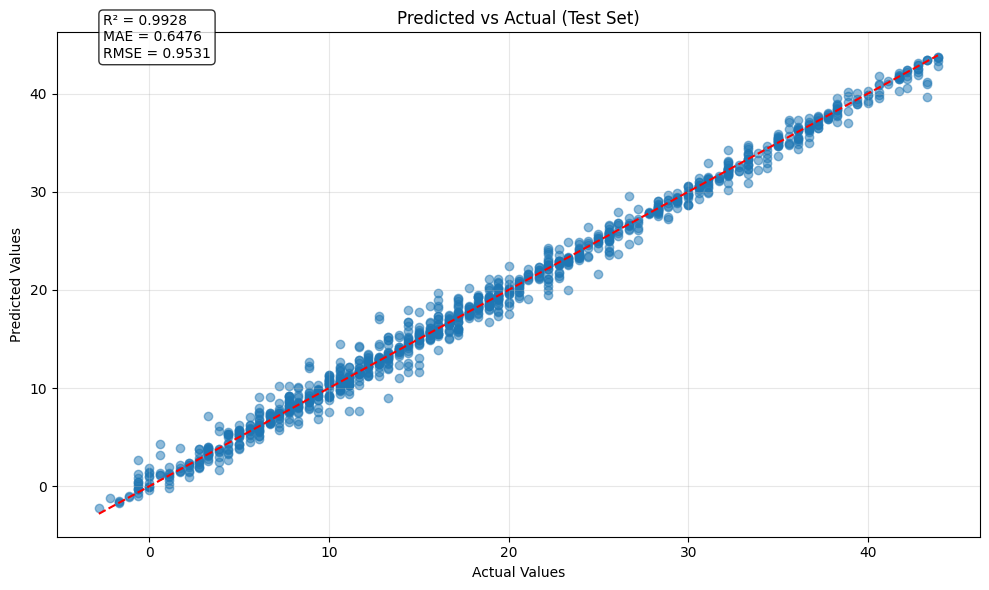

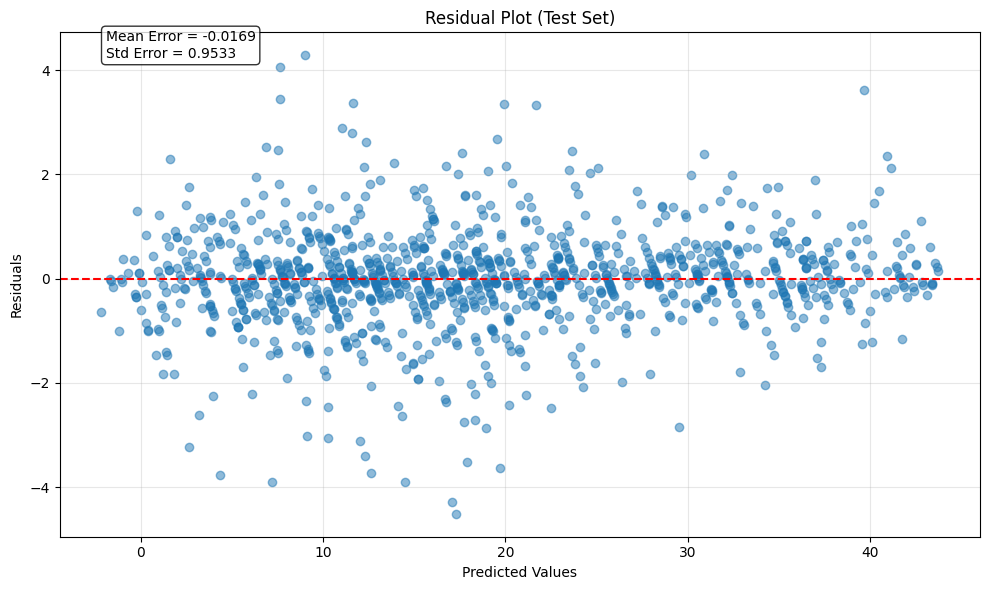

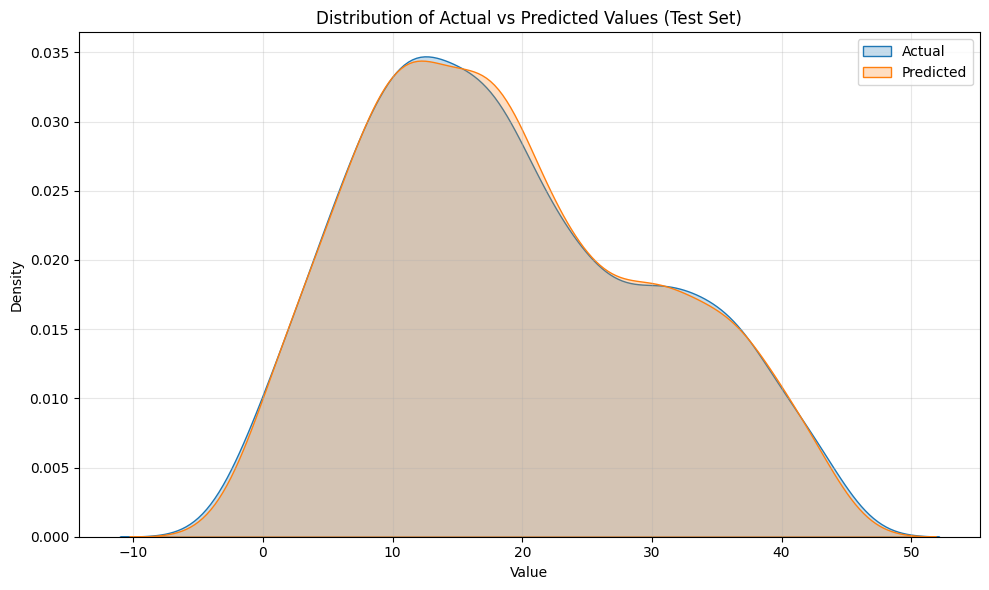


Performing Independent Hold-out Verification

Hold-out Verification Results:
Dataset    R²         MAE        RMSE      
----------------------------------------
holdout    0.9931     0.5889     0.9157    

Generating visualizations for hold-out verification data...


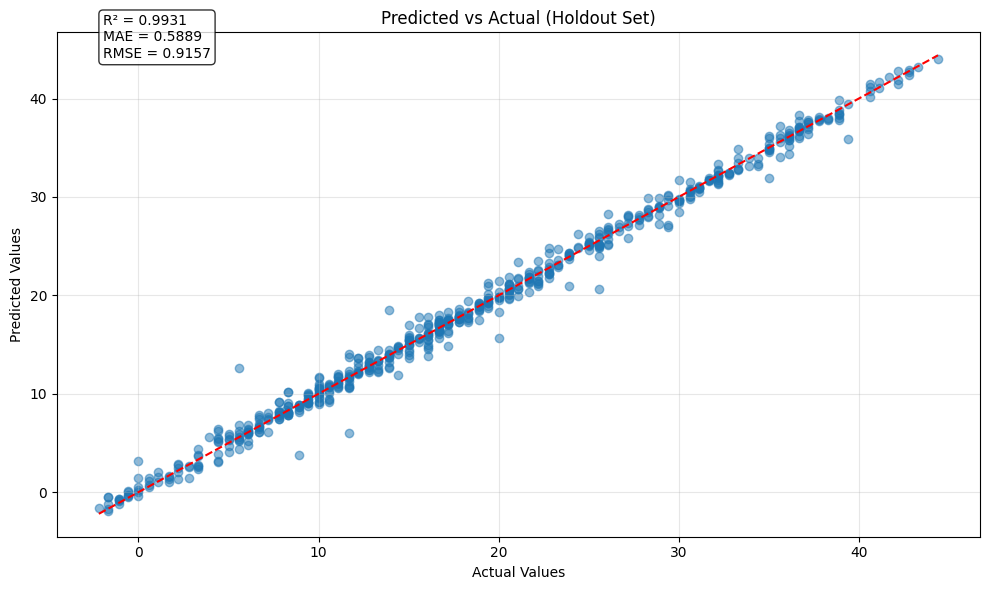

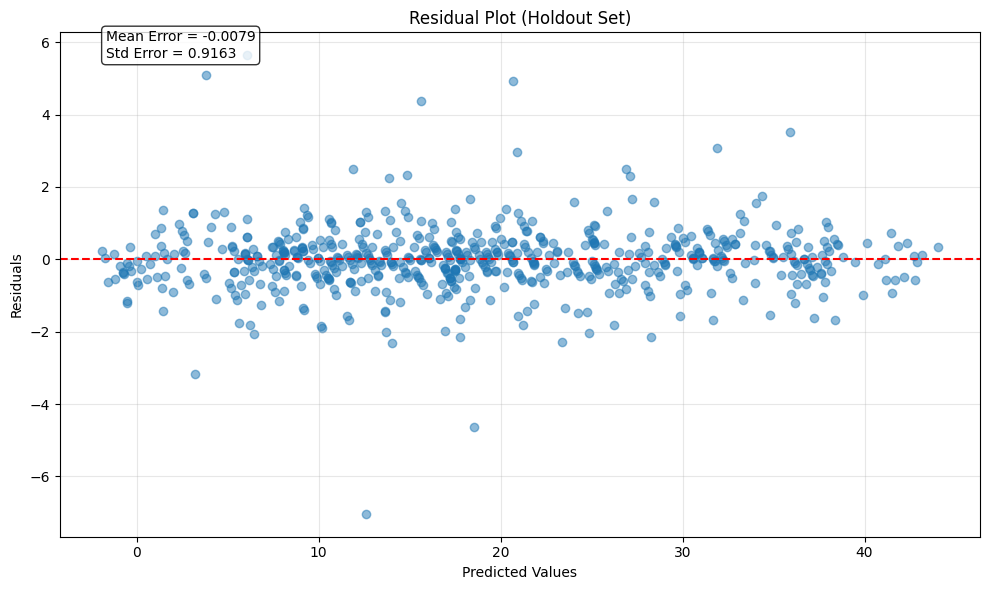

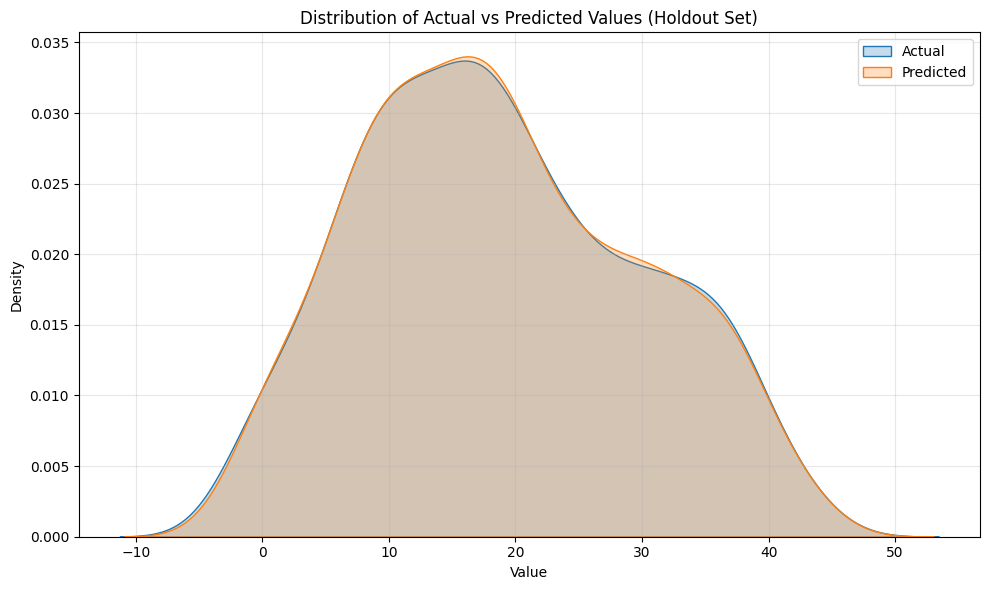


Workflow completed!


In [38]:
# Imports: Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
import glob
import warnings
warnings.filterwarnings('ignore')

# Imports: Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import various model types
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm
import catboost as cb

# Optional: GPU Support Check
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    GPU = True
else:
    print("PyTorch not available")
    GPU = None

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Current timestamp for logging
print(f"Current Date and Time (UTC): 2025-06-18 14:11:11")
print(f"Current User's Login: m-wessler")
print("-" * 50)

# ==============================
# CONFIGURATION SECTION
# ==============================

# Data Configuration
CONFIG = {
    # Data Settings
    'data_dir': '/content/',                          # Directory containing the data files
    'station_ids': ['KBOI'],                          # List of station IDs to process
    'forecast_hours': ['024'],                        # List of forecast hours to process
    'file_pattern': '{stid}_2000_2009_f{fhr}.csv',    # Pattern for filenames
    'target_variable': 'tmax_obs',                    # Target variable to predict

    # Feature Selection Settings
    'base_exclude_vars': ['sid', 'state', 'init_datetime', 'fcst_hour',
                          'perturbation', 'tmin_obs'],  # Variables always excluded
    'numeric_only': True,                             # Filter to keep only numeric columns

    # Model Settings
    'model_type': 'xgboost',                          # Options: 'linear', 'ridge', 'lasso',
                                                      # 'elasticnet', 'rf', 'gbm', 'xgboost',
                                                      # 'lightgbm', 'catboost'
    'model_params': {                                 # Model-specific parameters
        'xgboost': {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 10,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'gpu_hist' if GPU else None,
            'random_state': RANDOM_STATE,
            'early_stopping_rounds':20,
        },
        'lightgbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE
        },
        'rf': {
            'n_estimators': 200,
            'max_depth': 10,
            'min_samples_split': 5,
            'random_state': RANDOM_STATE
        },
        'linear': {},
        'ridge': {'alpha': 1.0},
        'lasso': {'alpha': 0.1},
        'elasticnet': {'alpha': 0.1, 'l1_ratio': 0.5},
        'gbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'random_state': RANDOM_STATE
        },
        'catboost': {
            'iterations': 200,
            'learning_rate': 0.1,
            'depth': 6,
            'random_state': RANDOM_STATE
        }
    },

    # Training Settings
    'holdout_size': 0.1,                              # Proportion of data for hold-out verification
    'test_size': 0.2,                                 # Proportion of remaining data for testing
    'val_size': 0.2,                                  # Proportion of training data for validation
    'cv_folds': 5,                                    # Number of cross-validation folds

    # Preprocessing Settings
    'add_day_of_year': True,                          # Add day-of-year feature
    'standardize_features': False,                    # Standardize features
    'handle_missing': True,                           # Handle missing values

    # Visualization Settings
    'show_feature_importance': True,                  # Show feature importance plot
    'show_scatter_plot': True,                        # Show scatter plot of predictions
    'show_residual_plot': True,                       # Show residual plot
    'show_distribution_plot': True,                   # Show distribution of predictions vs actual
    'show_error_by_feature': True,                    # Show error distribution by key features
    'top_n_features': 10                              # Number of top features to display
}

# ==============================
# DATA LOADING & PREPROCESSING
# ==============================

def filter_numeric_columns(df, target_variable):
    """Filter dataframe to keep only numeric columns and the target variable"""
    # Ensure target variable is kept regardless of type
    all_columns = df.columns.tolist()
    non_target_columns = [col for col in all_columns if col != target_variable]

    # Select numeric columns from non-target columns
    numeric_columns = df[non_target_columns].select_dtypes(include=['number']).columns.tolist()

    # Add target variable back
    if target_variable in all_columns:
        columns_to_keep = numeric_columns + [target_variable]
    else:
        columns_to_keep = numeric_columns

    # Filter the dataframe
    df_numeric = df[columns_to_keep]

    # Report columns dropped
    dropped_columns = [col for col in all_columns if col not in columns_to_keep]
    if dropped_columns:
        print(f"Dropped {len(dropped_columns)} non-numeric columns: {dropped_columns}")

    return df_numeric

def load_data(config):
    """Load and prepare the dataset based on configuration, handling multiple stations and forecast hours"""
    print(f"Loading data for {len(config['station_ids'])} station(s) and {len(config['forecast_hours'])} forecast hour(s)...")

    # Determine if we're using single or multiple stations
    is_single_station = len(config['station_ids']) == 1

    # Define which variables to exclude based on station count
    exclude_vars = config['base_exclude_vars'].copy()

    # For single station, exclude elevation and surface height as they're constant
    if is_single_station:
        exclude_vars.extend(['hgt_sfc', 'elev_ft'])
        print("Single station mode: 'hgt_sfc' and 'elev_ft' will be excluded as features")
    else:
        print("Multi-station mode: 'hgt_sfc' and 'elev_ft' will be included as features")

    # Create list to hold all dataframes
    all_dfs = []

    # Loop through all combinations of station IDs and forecast hours
    for stid in config['station_ids']:
        for fhr in config['forecast_hours']:
            # Construct file path
            file_path = os.path.join(
                config['data_dir'],
                config['file_pattern'].format(stid=stid, fhr=fhr)
            )

            print(f"  Loading file: {file_path}")

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"  WARNING: File not found: {file_path}")
                continue

            # Load the CSV file
            try:
                df = pd.read_csv(file_path)

                # Add station and forecast hour as columns if multiple stations/hours
                if len(config['station_ids']) > 1:
                    df['station_id'] = stid
                if len(config['forecast_hours']) > 1:
                    df['forecast_hour'] = fhr

                all_dfs.append(df)
                print(f"  Successfully loaded {len(df)} rows")
            except Exception as e:
                print(f"  ERROR loading {file_path}: {str(e)}")

    # Concatenate all dataframes
    if not all_dfs:
        raise ValueError("No data files were successfully loaded!")

    df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset: {df.shape[0]} rows, {df.shape[1]} columns")

    # For single station, set constant values for hgt_sfc and elev_ft
    if is_single_station:
        df['hgt_sfc'] = df['hgt_sfc'].iloc[0]
        df['elev_ft'] = df['elev_ft'].iloc[0]

    # Convert datetime column if present
    if 'valid_datetime' in df.columns:
        df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

        # Add day of year if configured
        if config['add_day_of_year']:
            df['doy'] = df['valid_datetime'].dt.dayofyear
            print("Added day-of-year feature")

        # Set datetime as index
        df.set_index('valid_datetime', inplace=True)

    # Drop excluded variables
    if exclude_vars:
        exclude_cols = [col for col in exclude_vars if col in df.columns]
        df = df.drop(columns=exclude_cols)
        print(f"Excluded {len(exclude_cols)} variables: {exclude_cols}")

    # Filter for numeric columns only if configured
    if config['numeric_only']:
        original_col_count = df.shape[1]
        df = filter_numeric_columns(df, config['target_variable'])
        print(f"Filtered to {df.shape[1]} numeric columns from {original_col_count} total columns")

    # Handle missing values if configured
    if config['handle_missing']:
        original_rows = len(df)
        df.dropna(inplace=True)
        dropped_rows = original_rows - len(df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing values ({dropped_rows/original_rows:.2%} of data)")

    print(f"Final dataset shape: {df.shape}")
    return df

def prepare_data_splits(df, config):
    """Split data into features and target, with hold-out, train, validation, and test sets"""
    # Separate features and target
    X = df.drop(columns=[config['target_variable']])
    y = df[config['target_variable']]

    # First split to separate hold-out data (10% of all data)
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        X, y,
        test_size=config['holdout_size'],
        random_state=RANDOM_STATE
    )

    # Second split for test set (20% of main data)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_main, y_main,
        test_size=config['test_size'],
        random_state=RANDOM_STATE
    )

    # Third split for validation set (20% of temp data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=config['val_size'],
        random_state=RANDOM_STATE
    )

    print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%} of data)")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df):.1%} of data)")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%} of data)")
    print(f"Hold-out set: {X_holdout.shape[0]} samples ({X_holdout.shape[0]/len(df):.1%} of data)")

    return X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout

# ==============================
# MODEL DEFINITION & TRAINING
# ==============================

def get_model(config):
    """Initialize model based on configuration"""
    model_type = config['model_type'].lower()
    model_params = config['model_params'].get(model_type, {})

    if model_type == 'linear':
        return LinearRegression(**model_params)
    elif model_type == 'ridge':
        return Ridge(**model_params)
    elif model_type == 'lasso':
        return Lasso(**model_params)
    elif model_type == 'elasticnet':
        return ElasticNet(**model_params)
    elif model_type == 'rf':
        return RandomForestRegressor(**model_params)
    elif model_type == 'gbm':
        return GradientBoostingRegressor(**model_params)
    elif model_type == 'xgboost':
        return XGBRegressor(**model_params)
    elif model_type == 'lightgbm':
        return lgbm.LGBMRegressor(**model_params)
    elif model_type == 'catboost':
        return cb.CatBoostRegressor(**model_params, verbose=False)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def create_pipeline(config, model):
    """Create a pipeline with preprocessing steps and model"""
    steps = []

    # Add preprocessing steps if configured
    if config['standardize_features']:
        steps.append(('scaler', StandardScaler()))

    # Add the model
    steps.append(('model', model))

    return Pipeline(steps)

def train_model(pipeline, X_train, y_train, X_val, y_val, config):
    """Train the model with early stopping if supported"""
    model_type = config['model_type'].lower()
    model = pipeline.named_steps['model']

    start_time = time.time()
    print(f"Training {model_type.upper()} model...")

    # Handle models that support early stopping
    if model_type in ['xgboost', 'lightgbm', 'catboost']:
        if model_type == 'xgboost':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_type == 'lightgbm':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20,
                verbose=False
            )
        elif model_type == 'catboost':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20,
                verbose=False
            )
    else:
        # For models without early stopping
        pipeline.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Model training completed in {training_time:.2f} seconds")

    return pipeline

def evaluate_model(pipeline, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluate model on training, validation, and test sets"""
    results = {}

    # Evaluate on training set
    y_train_pred = pipeline.predict(X_train)
    results['train'] = {
        'r2': r2_score(y_train, y_train_pred),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'actual': y_train,
        'predicted': y_train_pred
    }

    # Evaluate on validation set
    y_val_pred = pipeline.predict(X_val)
    results['val'] = {
        'r2': r2_score(y_val, y_val_pred),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'actual': y_val,
        'predicted': y_val_pred
    }

    # Evaluate on test set
    y_test_pred = pipeline.predict(X_test)
    results['test'] = {
        'r2': r2_score(y_test, y_test_pred),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'actual': y_test,
        'predicted': y_test_pred
    }

    # Print results
    print("\nModel Evaluation Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    for dataset, metrics in results.items():
        print(f"{dataset:<10} {metrics['r2']:<10.4f} {metrics['mae']:<10.4f} {metrics['rmse']:<10.4f}")

    return results

def evaluate_holdout(pipeline, X_holdout, y_holdout):
    """Evaluate model on hold-out verification dataset"""
    # Predict on hold-out set
    y_holdout_pred = pipeline.predict(X_holdout)

    # Calculate metrics
    holdout_results = {
        'holdout': {
            'r2': r2_score(y_holdout, y_holdout_pred),
            'mae': mean_absolute_error(y_holdout, y_holdout_pred),
            'rmse': np.sqrt(mean_squared_error(y_holdout, y_holdout_pred)),
            'actual': y_holdout,
            'predicted': y_holdout_pred
        }
    }

    # Print results
    print("\nHold-out Verification Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    print(f"{'holdout':<10} {holdout_results['holdout']['r2']:<10.4f} "
          f"{holdout_results['holdout']['mae']:<10.4f} "
          f"{holdout_results['holdout']['rmse']:<10.4f}")

    return holdout_results

def get_feature_importance(pipeline, X):
    """Extract feature importance from the model if available"""
    model = pipeline.named_steps['model']
    model_type = type(model).__name__

    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'coef_'):
        # For linear models
        importances = np.abs(model.coef_)
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'get_booster'):
        # For XGBoost
        importance_dict = model.get_booster().get_score(importance_type='gain')
        # Convert to Series with all features (some may be missing in the dict)
        all_features = pd.Series(0, index=X.columns)
        known_features = pd.Series(importance_dict)
        all_features.update(known_features)
        return all_features
    else:
        print(f"Feature importance not available for {model_type}")
        return None

# ==============================
# VISUALIZATION FUNCTIONS
# ==============================

def plot_feature_importance(feature_importance, config):
    """Plot feature importance"""
    if feature_importance is None:
        print("Feature importance not available for this model")
        return

    # Sort and get top N features
    n = config['top_n_features']
    top_features = feature_importance.sort_values(ascending=False).head(n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f'Top {n} Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

def plot_scatter_predictions(results, dataset='test'):
    """Plot scatter plot of predictions vs actual values"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    plt.figure(figsize=(10, 6))

    # Plot scatter points
    plt.scatter(actual, predicted, alpha=0.5)

    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'Predicted vs Actual ({dataset.capitalize()} Set)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True, alpha=0.3)

    # Add metrics as text
    r2 = results[dataset]['r2']
    mae = results[dataset]['mae']
    rmse = results[dataset]['rmse']
    plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_residuals(results, dataset='test'):
    """Plot residuals (errors)"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']
    residuals = actual - predicted

    plt.figure(figsize=(10, 6))

    # Scatter plot of residuals
    plt.scatter(predicted, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.title(f'Residual Plot ({dataset.capitalize()} Set)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)

    # Add metrics
    plt.annotate(f'Mean Error = {residuals.mean():.4f}\nStd Error = {residuals.std():.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_distributions(results, dataset='test'):
    """Plot distributions of actual and predicted values"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    plt.figure(figsize=(10, 6))

    sns.kdeplot(actual, label='Actual', shade=True)
    sns.kdeplot(predicted, label='Predicted', shade=True)

    plt.title(f'Distribution of Actual vs Predicted Values ({dataset.capitalize()} Set)')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_error_by_feature(results, X, feature_name, dataset='test', bins=20):
    """Plot error distribution by a specific feature"""
    if feature_name not in X.columns:
        print(f"Feature '{feature_name}' not found in dataset")
        return

    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']
    feature_values = X.loc[actual.index, feature_name]
    errors = actual - predicted

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame({
        'Feature': feature_values,
        'Error': errors
    })

    # Calculate bin statistics
    df_plot['Bin'] = pd.cut(df_plot['Feature'], bins=bins)
    bin_stats = df_plot.groupby('Bin')['Error'].agg(['mean', 'std', 'count'])
    bin_centers = [(interval.left + interval.right)/2 for interval in bin_stats.index]

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot individual errors as scatter
    ax1.scatter(df_plot['Feature'], df_plot['Error'], alpha=0.2, label='Individual Errors')

    # Plot bin means with error bars
    ax1.errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'],
                fmt='o-', color='red', ecolor='red', label='Bin Mean ± Std')

    # Plot zero line
    ax1.axhline(y=0, color='black', linestyle='--')

    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Error (Actual - Predicted)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot histogram of feature on secondary y-axis
    ax2 = ax1.twinx()
    sns.histplot(feature_values, bins=bins, alpha=0.3, ax=ax2, color='gray')
    ax2.set_ylabel('Frequency')

    plt.title(f'Error Distribution by {feature_name}')
    plt.tight_layout()
    plt.show()

# ==============================
# MAIN WORKFLOW
# ==============================

def run_workflow(config):
    """Run the complete ML workflow based on configuration"""
    print("Starting ML Post-Processing Workflow")
    stations_str = ', '.join(config['station_ids'])
    fhrs_str = ', '.join(config['forecast_hours'])
    print(f"Model: {config['model_type'].upper()}")
    print(f"Stations: {stations_str}")
    print(f"Forecast Hours: {fhrs_str}")
    print("-" * 50)

    # Load and prepare data
    df = load_data(config)

    # Split data (including hold-out set)
    X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout = prepare_data_splits(df, config)

    # Get model and create pipeline
    model = get_model(config)
    pipeline = create_pipeline(config, model)

    # Train model
    trained_pipeline = train_model(pipeline, X_train, y_train, X_val, y_val, config)

    # Evaluate model on training, validation, and test sets
    results = evaluate_model(trained_pipeline, X_train, y_train, X_val, y_val, X_test, y_test)

    # Get feature importance if available
    feature_importance = get_feature_importance(trained_pipeline, X_train)

    # Visualizations based on configuration
    print("\nGenerating visualizations for training/validation/test data...")

    if config['show_feature_importance'] and feature_importance is not None:
        plot_feature_importance(feature_importance, config)

    if config['show_scatter_plot']:
        plot_scatter_predictions(results)

    if config['show_residual_plot']:
        plot_residuals(results)

    if config['show_distribution_plot']:
        plot_distributions(results)

    if config['show_error_by_feature'] and feature_importance is not None:
        # Plot error by top feature
        top_feature = feature_importance.sort_values(ascending=False).index[0]
        try:
            plot_error_by_feature(results, X_test, top_feature)
        except:
            pass

    # Now evaluate on hold-out verification dataset
    print("\n" + "="*50)
    print("Performing Independent Hold-out Verification")
    print("="*50)

    holdout_results = evaluate_holdout(trained_pipeline, X_holdout, y_holdout)

    # Generate visualizations for hold-out data
    print("\nGenerating visualizations for hold-out verification data...")

    if config['show_scatter_plot']:
        plot_scatter_predictions(holdout_results, dataset='holdout')

    if config['show_residual_plot']:
        plot_residuals(holdout_results, dataset='holdout')

    if config['show_distribution_plot']:
        plot_distributions(holdout_results, dataset='holdout')

    if config['show_error_by_feature'] and feature_importance is not None:
        # Plot error by top feature
        top_feature = feature_importance.sort_values(ascending=False).index[0]
        try:
            plot_error_by_feature(holdout_results, X_holdout, top_feature, dataset='holdout')
        except:
            pass

    print("\nWorkflow completed!")
    return trained_pipeline, results, holdout_results, feature_importance

# ==============================
# EXECUTE WORKFLOW
# ==============================

# Customize your station IDs and forecast hours here
CONFIG['station_ids'] = ['KBOI', 'KSLC', 'KSEA', 'KLAS']  # Example: multiple stations
CONFIG['forecast_hours'] = ['024']  # Example: multiple forecast hours

# Run the workflow with the defined configuration
trained_pipeline, results, holdout_results, feature_importance = run_workflow(CONFIG)

# Optional: Save model
# from joblib import dump
# dump(trained_pipeline, f"{CONFIG['model_type']}_model.joblib")